# Template - Strategy - Backtesting 

### Import Library

In [22]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
from backtesting._plotting import set_bokeh_output
set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [23]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [24]:
data = dataset.copy()

In [25]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [26]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.4,1342.4,1344.2,5075
2025-02-07 14:20:00,1344.2,1344.7,1343.6,1344.0,4865
2025-02-07 14:25:00,1344.1,1344.2,1342.8,1343.3,5013


In [27]:
def cal_signal(r):
    signal = ''
    if r['price_move'] > 0.5 * r['ATR'] and r['Low_s1'] == r['min_10'] and r['Close_s1'] < r['Open_s1'] and r['Close'] > (r['Close_s1'] + r['Open_s1']) / 2:
        if r['Close'] > r['ema_low']:
            signal = 'long'
        else:
            signal = 'close_short'
    elif abs(r['price_move']) > 0.5 * r['ATR'] and r['High_s1'] == r['max_10'] and r['Close_s1'] > r['Open_s1'] and r['Close'] < (r['Close_s1'] + r['Open_s1']) / 2:
        if r['Close'] < r['ema_low']:
            signal = 'short'
        else:
            signal = 'close_long'
    return signal

def prepare_data(data):
    data['Close_s1'] = data['Close'].shift(1)
    data['High_s1'] = data['High'].shift(1)
    data['Low_s1'] = data['Low'].shift(1)
    data['Open_s1'] = data['Open'].shift(1)
    data["ATR"] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
    data['price_move'] = data.apply(lambda r: r['Close'] - r['Close_s1'], axis=1)
    data['max_10'] = data['High'].rolling(10).max()
    data['min_10'] = data['Low'].rolling(10).min()
    data["ema_low"] = ta.ema(data["Close"], length=250)
    data['signal'] = data.apply(lambda r: cal_signal(r), axis=1)
    return data

In [28]:
class MainStrategy(Strategy):
    reward_on_risk = 3
    def init(self):
        self._broker._cash = 2500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return

        signal = self.data.signal[-1]
        close_price = self.data.Close[-1]
        open_price = self.data.Open[-1]
        if self.position:
             if (self.position.is_long and signal == 'close_long') or (self.position.is_short and signal == 'close_short'):
                 self.position.close()
        else:
            if signal == 'long':
                min_10 = self.data.min_10[-1]
                buy_price = close_price
                sl = min_10 - 0.1
                risk = buy_price - sl
                tp = buy_price + risk + self.reward_on_risk
                self.buy(size=1, sl=sl, tp=tp)
            elif signal == 'short':
                max_10 = self.data.max_10[-1]
                sell_price = close_price
                sl = max_10 + 0.1
                risk = sl - sell_price
                tp = sell_price - risk * self.reward_on_risk
                self.sell(size=1, sl=sl, tp=tp)

In [29]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [30]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [31]:
stats

Start                     2020-11-06 14:10:00
End                       2025-02-07 14:45:00
Duration                   1554 days 00:35:00
Exposure Time [%]                    9.854015
Equity Final [$]                   2256.93459
Equity Peak [$]                    2573.05755
Return [%]                          -9.722616
Buy & Hold Return [%]               47.453348
Return (Ann.) [%]                   -2.402313
Volatility (Ann.) [%]                2.414463
Sharpe Ratio                        -0.994967
Sortino Ratio                       -1.403338
Calmar Ratio                        -0.177496
Max. Drawdown [%]                   -13.53448
Avg. Drawdown [%]                   -0.923494
Max. Drawdown Duration     1414 days 01:35:00
Avg. Drawdown Duration       73 days 00:23:00
# Trades                                  795
Win Rate [%]                        35.597484
Best Trade [%]                       2.328735
Worst Trade [%]                     -1.198999
Avg. Trade [%]                    

In [32]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,1,40,41,919.27570,918.0,-1.27570,-0.001388,2020-11-09 13:15:00,2020-11-09 13:20:00,None,0 days 00:05:00
1,1,128,136,921.27630,919.3,-1.97630,-0.002145,2020-11-11 10:40:00,2020-11-11 11:20:00,None,0 days 00:40:00
2,1,250,257,931.87948,935.8,3.92052,0.004207,2020-11-13 13:55:00,2020-11-13 14:30:00,None,0 days 00:35:00
3,1,302,304,933.68002,925.4,-8.28002,-0.008868,2020-11-16 14:00:00,2020-11-16 14:10:00,None,0 days 00:10:00
4,1,454,459,940.28200,945.7,5.41800,0.005762,2020-11-19 13:55:00,2020-11-19 14:20:00,None,0 days 00:25:00
...,...,...,...,...,...,...,...,...,...,...,...
790,1,53542,53556,1324.99738,1322.8,-2.19738,-0.001658,2025-01-21 10:55:00,2025-01-21 13:30:00,None,0 days 02:35:00
791,1,53718,53720,1344.60326,1342.4,-2.20326,-0.001639,2025-01-24 14:15:00,2025-01-24 14:25:00,None,0 days 00:10:00
792,1,53864,53868,1331.49933,1335.9,4.40067,0.003305,2025-02-05 13:40:00,2025-02-05 14:00:00,None,0 days 00:20:00
793,1,53916,53925,1339.50173,1339.4,-0.10173,-0.000076,2025-02-06 13:45:00,2025-02-06 14:30:00,None,0 days 00:45:00


In [33]:
# bt.plot()

In [35]:
trades = stats['_trades']

In [37]:
trades['PnL'].max()

24.1882999999998

In [38]:
trades['PnL'].min()

-16.205600000000004

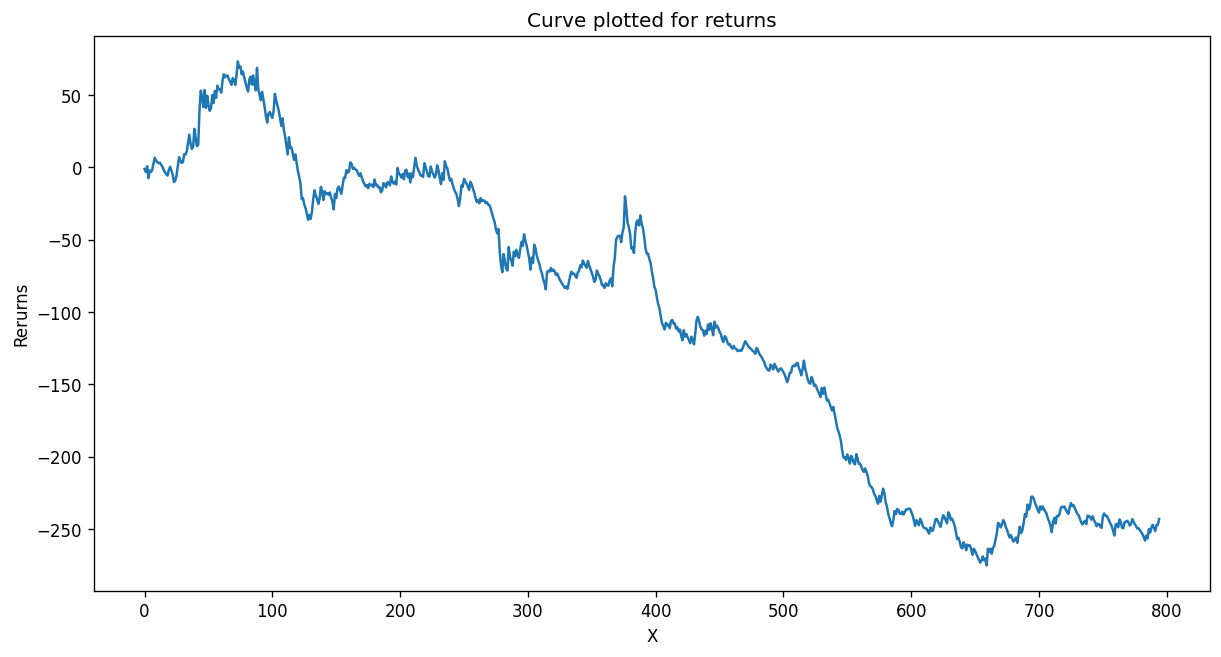

In [36]:
copy_trades = trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

In [34]:
prepared_data[prepared_data.signal != ''].tail(10)

,Open,High,Low,Close,Volume,Close_s1,High_s1,Low_s1,Open_s1,ATR,price_move,max_10,min_10,ema_low,signal
Date,,,,,,,,,,,,,,,
2025-02-03 13:40:00,1318.3,1319.8,1317.9,1319.5,2537,1318.2,1319.9,1317.8,1319.3,1.676898,1.3,1322.8,1317.8,1327.408960,close_short
2025-02-04 10:55:00,1320.7,1322.5,1320.6,1322.5,3408,1320.7,1321.1,1320.6,1321.0,1.482922,1.8,1324.9,1320.6,1325.930695,close_short
2025-02-04 13:15:00,1329.2,1329.2,1327.0,1327.5,4471,1329.2,1329.5,1326.4,1326.8,1.725964,-1.7,1329.5,1324.3,1325.961493,close_long
2025-02-04 14:05:00,1329.1,1329.7,1327.3,1327.5,3797,1329.3,1329.8,1328.3,1328.3,1.623180,-1.8,1329.8,1326.2,1326.109519,close_long
2025-02-05 10:20:00,1337.2,1337.7,1336.1,1336.1,2712,1337.2,1337.8,1336.7,1336.8,1.508177,-1.1,1337.8,1333.4,1327.306378,close_long
2025-02-05 13:35:00,1330.4,1331.4,1330.4,1331.2,1733,1330.3,1331.1,1329.6,1330.8,1.074511,0.9,1332.6,1329.6,1328.210065,long
2025-02-06 13:40:00,1338.1,1339.5,1337.6,1339.1,3453,1338.1,1338.3,1337.2,1338.3,1.218713,1.0,1342.6,1337.2,1332.134826,long
2025-02-07 09:20:00,1335.2,1336.6,1335.2,1336.4,3481,1335.2,1338.0,1335.0,1336.9,1.589599,1.2,1341.6,1335.0,1332.994685,long
2025-02-07 10:55:00,1338.3,1340.1,1338.3,1340.1,3682,1338.3,1338.5,1337.6,1338.4,1.308556,1.8,1340.2,1337.6,1333.746583,long
